In [1]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

In [2]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 20
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "../PlantVillage"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = ds.cardinality().numpy()
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "PlantVillage",
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 4500 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


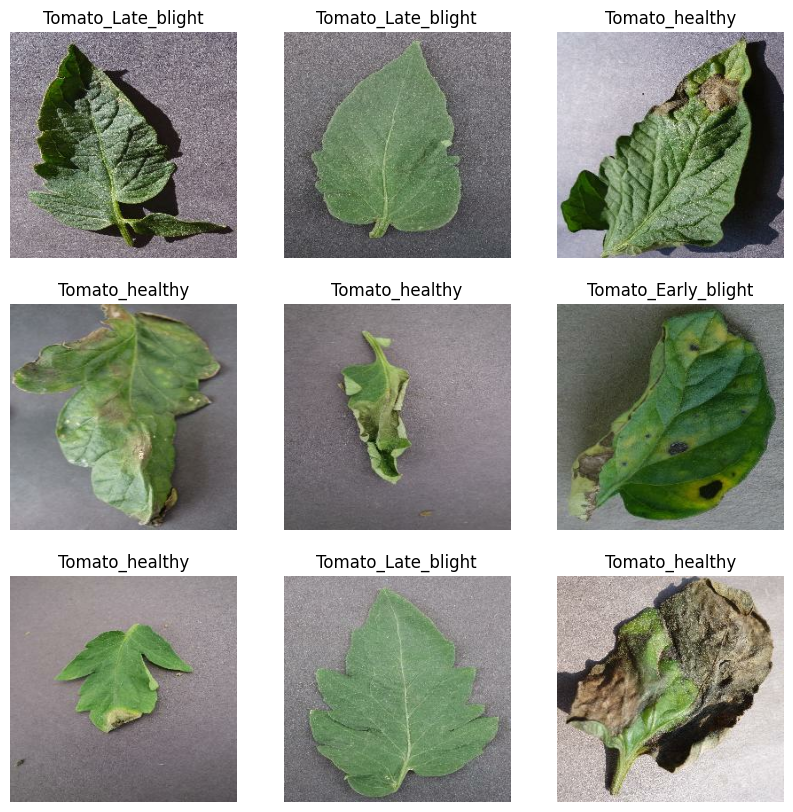

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/20
112/112 [==============================] - 584s 5s/step - loss: 0.7182 - accuracy: 0.6873 - val_loss: 0.5252 - val_accuracy: 0.7729
Epoch 2/20
112/112 [==============================] - 337s 3s/step - loss: 0.5961 - accuracy: 0.7441 - val_loss: 0.8980 - val_accuracy: 0.6720
Epoch 3/20
112/112 [==============================] - 241s 2s/step - loss: 0.3658 - accuracy: 0.8438 - val_loss: 0.2934 - val_accuracy: 0.8761
Epoch 4/20
112/112 [==============================] - 237s 2s/step - loss: 0.3573 - accuracy: 0.8471 - val_loss: 0.2633 - val_accuracy: 0.8899
Epoch 5/20
112/112 [==============================] - 233s 2s/step - loss: 0.3539 - accuracy: 0.8539 - val_loss: 0.2922 - val_accuracy: 0.8876
Epoch 6/20
112/112 [==============================] - 221s 2s/step - loss: 0.2841 - accuracy: 0.8838 - val_loss: 0.3564 - val_accuracy: 0.8670
Epoch 7/20
112/112 [==============================] - 214s 2s/step - loss: 0.3358 - accuracy: 0.8645 - val_loss: 0.2404 - val_accuracy: 0.8922

In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
15/15 [==============================] - 74s 1s/step - loss: 0.1900 - accuracy: 0.9292
Test Accuracy: 92.92%


In [17]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [18]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 quant_conv2d (QuantizeWrap  (None, 254, 254, 32)      963       
 perV2)                                                          
                                                                 
 quant_max_pooling2d (Quant  (None, 127, 127, 32)      1         
 izeWrapperV2)                                                   
                                                                 
 quant_conv2d_1 (QuantizeWr  (None, 125, 125, 64)      18627     
 apperV2)                                                        
                                                      

In [19]:
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
112/112 [==============================] - 593s 5s/step - loss: 0.1817 - accuracy: 0.9306 - val_loss: 0.1723 - val_accuracy: 0.9220
Epoch 2/20
112/112 [==============================] - 803s 7s/step - loss: 0.1549 - accuracy: 0.9406 - val_loss: 0.3162 - val_accuracy: 0.8991
Epoch 3/20
112/112 [==============================] - 478s 4s/step - loss: 0.1535 - accuracy: 0.9457 - val_loss: 0.1202 - val_accuracy: 0.9518
Epoch 4/20
112/112 [==============================] - 262s 2s/step - loss: 0.1495 - accuracy: 0.9434 - val_loss: 0.1017 - val_accuracy: 0.9587
Epoch 5/20
112/112 [==============================] - 305s 3s/step - loss: 0.1564 - accuracy: 0.9378 - val_loss: 0.1507 - val_accuracy: 0.9335
Epoch 6/20
112/112 [==============================] - 307s 3s/step - loss: 0.1376 - accuracy: 0.9485 - val_loss: 0.1024 - val_accuracy: 0.9495
Epoch 7/20
112/112 [==============================] - 304s 3s/step - loss: 0.1234 - accuracy: 0.9558 - val_loss: 0.1288 - val_accuracy: 0.9518

In [21]:
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating Quant Aware model accuracy
15/15 [==============================] - 11s 719ms/step - loss: 0.4104 - accuracy: 0.8646
Test Accuracy: 86.46000000000001%


In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\SAHILB~1\AppData\Local\Temp\tmpzd_l5qik\assets


INFO:tensorflow:Assets written to: C:\Users\SAHILB~1\AppData\Local\Temp\tmpzd_l5qik\assets
C:\Users\Sahil B\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [24]:
def evaluate_tflite_model(dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

Quant TFLite test_accuracy: 0.874


In [25]:
import os
model_version = max([int(i) for i in (os.listdir("../tf-lite-models")+[0])]) + 1

with open(
    f"../tf-lite-models/{model_version}.tflite",
    'wb'
) as f:
    f.write(quantized_tflite_model)

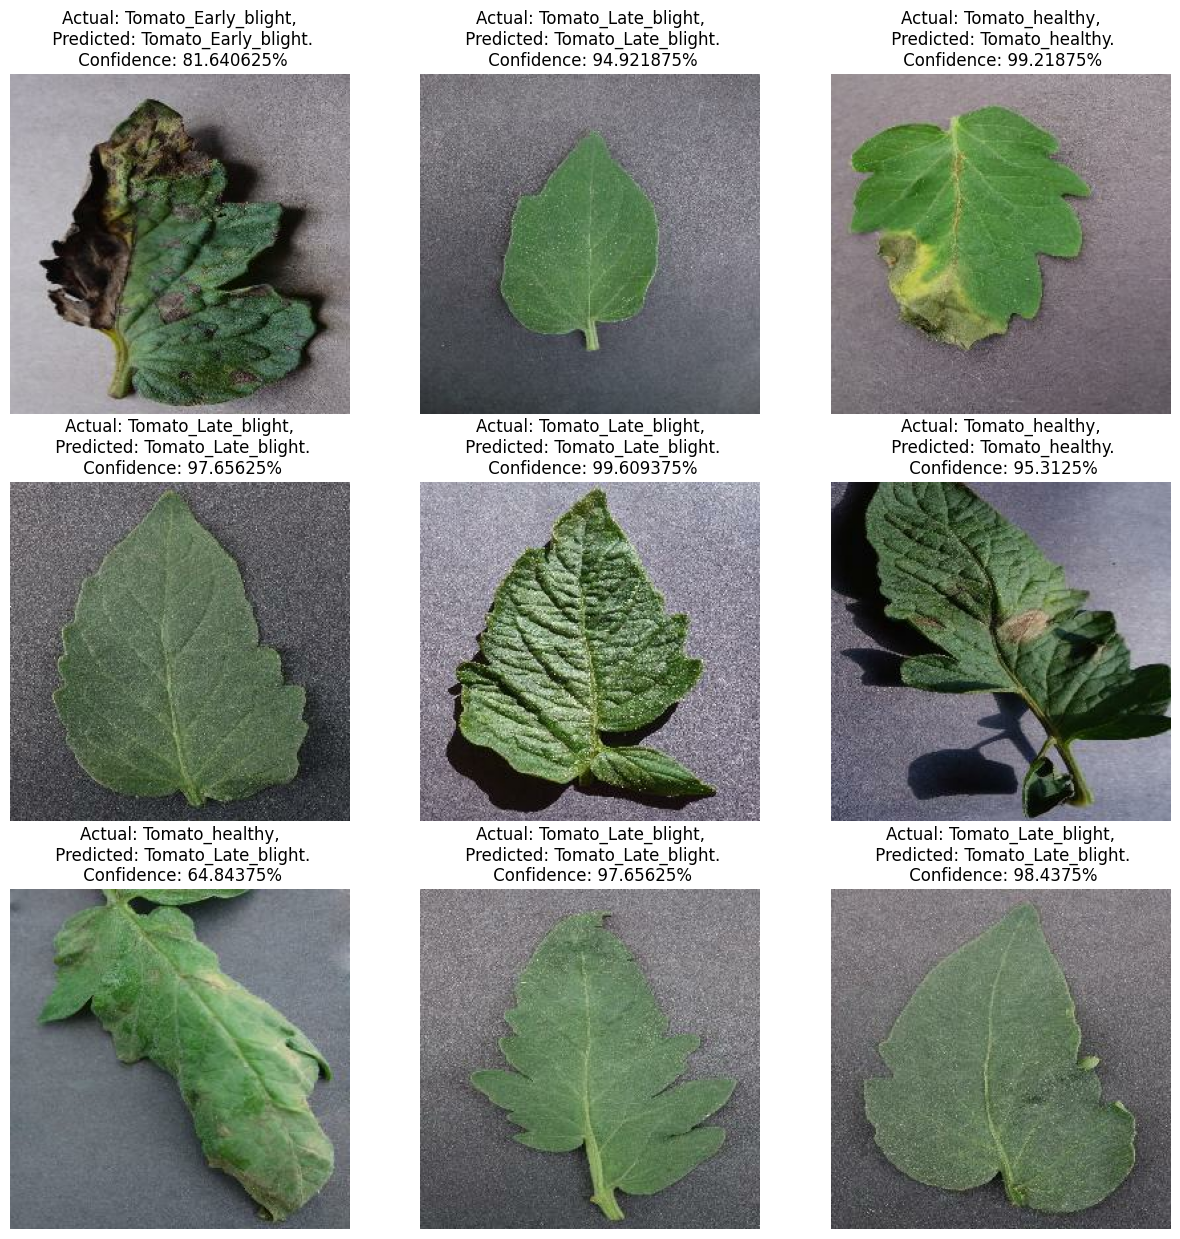

In [26]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")